In [1]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import tree 
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import plotly.express as px

sns.set_style('whitegrid')

In [2]:
Reading pre-loaded and prepared data
df=pd.read_csv('df_uda.csv', sep='\t')  

## Train/Test Spliting and Vectorizing

The TF-IDF Vectorizer is used, which takes into account how frequent a word appears in a document and also how unqiue the word is in overall corpus. In order to capture the most meaningful words, we cut off the top 10% and bottom 5% of words.

In [7]:
X = df['tokenized'].astype(str)

y = df['new_rating'].astype(str)

In [8]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.05,  ngram_range=(1, 1))

In [9]:

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

In [10]:
pd.set_option('display.max_rows', None)

wm = tfidf_train.fit_transform(X_train)
tokens = tfidf_train.get_feature_names()

wm.shape
doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
data = pd.DataFrame(data=wm.toarray(), index=doc_names,
                  columns=tokens)
data.mean().sort_values()

/Users/d.kandalina/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


leave          0.012791
balcony        0.013086
arrive         0.013229
everyone       0.013296
far            0.013436
quite          0.013520
small          0.013575
morning        0.013688
keep           0.013743
large          0.013814
ever           0.013896
find           0.013914
desk           0.014082
option         0.014267
shuttle        0.014282
hour           0.014437
smile          0.014633
overall        0.014655
week           0.014683
top            0.014752
right          0.014756
free           0.014827
ask            0.014895
quiet          0.014950
bit            0.014994
choice         0.015101
access         0.015122
sure           0.015189
use            0.015214
property       0.015398
manager        0.015465
care           0.015489
two            0.015495
super          0.015719
return         0.015820
work           0.015916
offer          0.015971
enough         0.016109
way            0.016173
little         0.016195
price          0.016240
thailand       0

## PCA

We tried to use PCA in order to reduce multidimensionality for some of the models.

In [11]:
pca = PCA(n_components=0.9, random_state=1)

pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

In [12]:
pca.n_components_

130

In [13]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_features)

pca1 = pca_result[:,0]
pca2 = pca_result[:,1] 
pca3 = pca_result[:,2]

target = pd.Categorical(y_train).codes

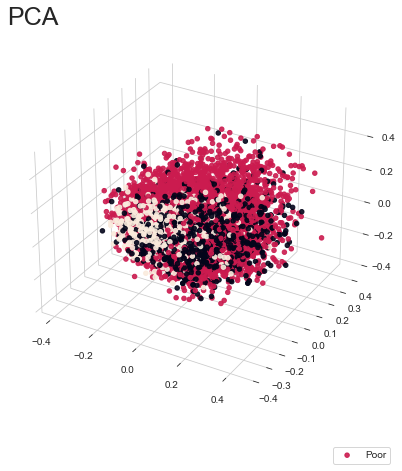

In [14]:
fig = plt.figure(figsize=(19, 7))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('PCA', fontsize=25, loc='left')
ax.scatter(xs=pca1, 
           ys=pca2, 
           zs=pca3, 
           c=target,
           alpha=.9,)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# ax.legend(['Poor','Average','Excellent'])

ax.legend(['Poor','Average','Excellent'], bbox_to_anchor=(1.02, -0.08))

#why isnt legend showing

## Main Part

Function for the evaluation of each model

In [15]:


def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

Next, we tried different models, both with and without PCA, to compare the results and choose the most appropriate model for our task.
Accuracy and F1-score were chosen as the main metrics by which models will be compared.

To select the best hyperparameters for each of the models, we used a grid search

### Naive Bayes

In [16]:
scorer = make_scorer(f1_score, average='weighted')

params=  {'alpha': [0.09, 0.1,0.11]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [17]:

grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [18]:

nb_train_preds = grid_search_nb.best_estimator_.predict(train_features)
nb_test_preds = grid_search_nb.best_estimator_.predict(test_features)
metrics_score(nb_train_preds, y_train, nb_test_preds, y_test)

Training Accuracy:	0.7606 	Testing Accuracy:	0.7678
Training Precision:	0.7541 	Testing Precision:	0.7531
Training Recall:	0.7606 	Testing Recall:		0.7678
Training F1:		0.6705 	Testing F1:		0.6785


The quality on the training and test sets is not much different, so we can conclude that the model has not overfitted

### Logisitic Regression

In [19]:
#scaling data
ss = StandardScaler()
train_scaled = ss.fit_transform(train_features)
test_scaled = ss.transform(test_features)

In [20]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)

In [21]:
grid_search_LR.fit(train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [22]:
lr_train_preds = grid_search_LR.best_estimator_.predict(train_scaled)
lr_test_preds = grid_search_LR.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds, y_train, lr_test_preds, y_test)

Training Accuracy:	0.7313 	Testing Accuracy:	0.6972
Training Precision:	0.8063 	Testing Precision:	0.7824
Training Recall:	0.7313 	Testing Recall:		0.6972
Training F1:		0.7529 	Testing F1:		0.7246


There is already a significant difference in the quality of the training and test samples, overfitting is possible

### Logisitic Regression with PCA

In [23]:

# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR_pca = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                                  cv = 3, n_jobs = -1, verbose = 2)

In [24]:
grid_search_LR_pca.fit(pca_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/d.kandalina/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [25]:
lr_train_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_train)
lr_test_preds_pca = grid_search_LR_pca.best_estimator_.predict(pca_test)
metrics_score(lr_train_preds_pca, y_train, lr_test_preds_pca, y_test)

Training Accuracy:	0.7208 	Testing Accuracy:	0.7022
Training Precision:	0.7999 	Testing Precision:	0.786
Training Recall:	0.7208 	Testing Recall:		0.7022
Training F1:		0.7442 	Testing F1:		0.7286


The difference is similar to the previous model, but the results are on average worse

### Decision Tree

In [26]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [27]:
grid_search_DT.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [28]:

dt_train_preds = grid_search_DT.best_estimator_.predict(train_features)
dt_test_preds = grid_search_DT.best_estimator_.predict(test_features)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)

Training Accuracy:	0.8695 	Testing Accuracy:	0.7461
Training Precision:	0.8766 	Testing Precision:	0.6965
Training Recall:	0.8695 	Testing Recall:		0.7461
Training F1:		0.8542 	Testing F1:		0.7117


The trees seem to have retrained. (In general, it is for them that this is the most characteristic and frequently encountered problem). If we understand that this model is better than the rest in terms of quality on the test, then it will be necessary to deal with the problem of overfitting in more detail.

### decision tree with PCA

In [29]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT_pca = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                                  cv = 5, n_jobs = -1, verbose = 2)

In [30]:
grid_search_DT_pca.fit(pca_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [31]:
dt_train_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_train)
dt_test_preds_pca = grid_search_DT_pca.best_estimator_.predict(pca_test)
metrics_score(dt_train_preds_pca, y_train, dt_test_preds_pca, y_test)

Training Accuracy:	0.8148 	Testing Accuracy:	0.7628
Training Precision:	0.7968 	Testing Precision:	0.7287
Training Recall:	0.8148 	Testing Recall:		0.7628
Training F1:		0.7981 	Testing F1:		0.7396


### random forest

In [32]:
params = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [33]:
grid_search_RF.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [34]:
rf_train_preds = grid_search_RF.best_estimator_.predict(train_features)
rf_test_preds = grid_search_RF.best_estimator_.predict(test_features)
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.7576 	Testing Accuracy:	0.7606
Training Precision:	0.8169 	Testing Precision:	0.7263
Training Recall:	0.7576 	Testing Recall:		0.7606
Training F1:		0.6617 	Testing F1:		0.6584


The model looks weaker than the previous ones, but the metrics on the test and the train are similar

### Light GBM

In [35]:

lgbm = LGBMClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'colsample_bytree': [0.7, 0.8],
              'max_depth': [15, 20],
              'num_leaves': [50, 100,],
              'min_split_gain': [0.3,0.4],
              'reg_alpha': [1.0, 1.1],
             'objective': ['multiclass'],
             'num_class':[3],
              'class_label':['weight']
             }

              
grid_lgbm = GridSearchCV(lgbm, param_grid, cv=2, verbose=1, n_jobs=-1)

In [36]:
grid_lgbm.fit(train_features, y_train)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[LightGBM] [Warning] Unknown parameter: class_label


GridSearchCV(cv=2, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_label': ['weight'],
                         'colsample_bytree': [0.7, 0.8], 'max_depth': [15, 20],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [50, 100], 'num_class': [3],
                         'num_leaves': [50, 100], 'objective': ['multiclass'],
                         'reg_alpha': [1.0, 1.1]},
             verbose=1)

In [37]:
gbm_train_preds = grid_lgbm.best_estimator_.predict(train_features)
gbm_test_preds = grid_lgbm.best_estimator_.predict(test_features)
metrics_score(gbm_train_preds, y_train, gbm_test_preds, y_test)

Training Accuracy:	0.9749 	Testing Accuracy:	0.8139
Training Precision:	0.9753 	Testing Precision:	0.7881
Training Recall:	0.9749 	Testing Recall:		0.8139
Training F1:		0.9743 	Testing F1:		0.7901


We see a huge difference between the training and training samples, this again indicates a likely overfitting. However, even on the test, the quality here is stronger than on previous models.

### KNN


As an experiment, we will also try to train the model without a teacher.

In [38]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['eucilidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, params, verbose = 1,
                        cv = 3, n_jobs =-1)

In [39]:
grid_knn.fit(train_scaled, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/d.kandalina/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/d.kandalina/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/d.kandalina/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/Users/d.kandalina/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_base.py", line 437, in _fi

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['eucilidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

## Comparing the results of all trained models:

In [41]:
model_candidates = [
    
    {'name':'Naive Bayes',
     'accuracy score':accuracy_score(y_test, nb_test_preds),
     'f1 score':metrics.f1_score(y_test, nb_test_preds, average='weighted')},
    
    {'name':'Logistic Regression',
     'accuracy score':accuracy_score(y_test, lr_test_preds),
     'f1 score':metrics.f1_score(y_test, lr_test_preds, average='weighted')},
    
    {'name':'Logistic Regression (PCA)',
     'accuracy score':accuracy_score(y_test, lr_test_preds_pca),
    'f1 score':metrics.f1_score(y_test, lr_test_preds_pca, average='weighted')},
    
    {'name':'Decision Tree',
     'accuracy score':accuracy_score(y_test, dt_test_preds),
     'f1 score':metrics.f1_score(y_test, dt_test_preds, average='weighted')},
    
    {'name':'Decision Tree (PCA)',
     'accuracy score':accuracy_score(y_test, dt_test_preds_pca),
     'f1 score':metrics.f1_score(y_test, dt_test_preds_pca, average='weighted')},
    
    {'name':'Random Forest',
     'accuracy score':accuracy_score(y_test, rf_test_preds),
     'f1 score':metrics.f1_score(y_test, rf_test_preds, average='weighted')},
    
    {'name':'Light GBM',
     'accuracy score':accuracy_score(y_test, gbm_test_preds),
     'f1 score':metrics.f1_score(y_test, gbm_test_preds, average='weighted')},
    
    {'name':'KNN',
     'accuracy score':accuracy_score(y_test, knn_test_preds),
    'f1 score':metrics.f1_score(y_test, knn_test_preds, average='weighted')}
 
]

In [42]:
final_result_df = pd.DataFrame(model_candidates).set_index('name')
final_result_df

,accuracy score,f1 score
name,,
Naive Bayes,0.767778,0.678534
Logistic Regression,0.697222,0.724605
Logistic Regression (PCA),0.702222,0.728622
Decision Tree,0.746111,0.711705
Decision Tree (PCA),0.762778,0.739605
Random Forest,0.760556,0.658438
Light GBM,0.813889,0.790127
KNN,0.794444,0.734661


Boosting trained by Light GBM proved to be the best. In terms of accuracy, the unsupervised model, KNN, also became a strong model, however, in terms of F1-score, it is weaker than decision trees using PCA, which is third in accuracy.
Confusion matrix for these three algorithms:


[Text(0, 0.5, 'Average'), Text(0, 1.5, 'Excellent'), Text(0, 2.5, 'Poor')]

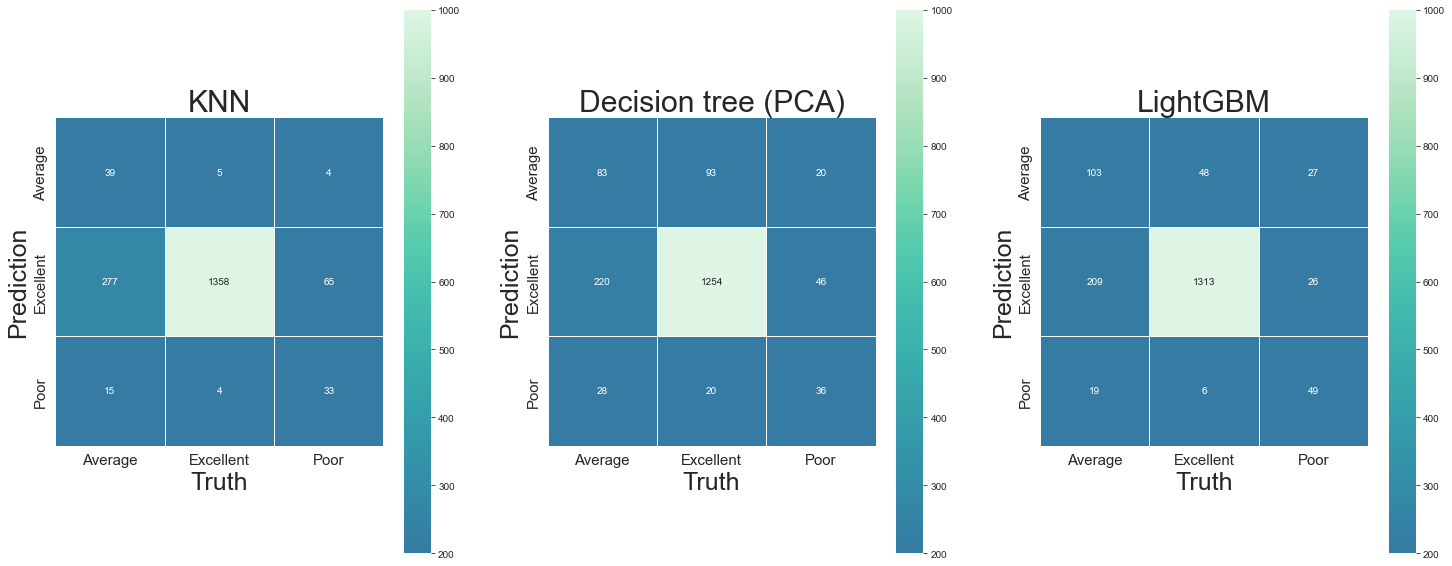

In [43]:
sns.color_palette("viridis", as_cmap=True)
# sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

# plot KNN confusion matrix
sns.heatmap(confusion_matrix(y_test, knn_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[0]).set_title('KNN', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[0].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot Decision tree (PCA) confusion matrix
sns.heatmap(confusion_matrix(y_test, dt_test_preds_pca).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[1]).set_title('Decision tree (PCA)', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[1].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot LightGBM confusion matrix
sns.heatmap(confusion_matrix(y_test, gbm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[2]).set_title('LightGBM', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[2].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

It turns out that Light GBM most well separates weak and medium reviews. However, it is interesting that the unsupervised method also performed quite well. This shows that companies have the ability not to ask for a rating and write a review at the same time, for fear of their inconsistency with each other, but to use clustering to rate based on the review